In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import datetime

from torch.utils.data import DataLoader
from torchvision import transforms
from dataset_utils import SegmentationDataset, read_dataset
from bisenetv2 import BiseNetV2
from unet import UNet
from loss_function import instance_loss
from config_utils import Config
from metrics import CalculateMetrics
from tqdm import tqdm
from utils import save_plot

torch.manual_seed(120)
random.seed(120)
np.random.seed(120)

torch.Size([8, 2, 512, 256]) torch.Size([8, 4, 512, 256])


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

CFG = Config(config_path='./lanenet.yml')
dataset_path = CFG.DATASET.TRAIN_FILE_LIST
num_samples = CFG.DATASET.MAX_NUM_SAMPLES
# num_samples = 10
img_size = CFG.DATASET.IMAGE_SIZE
val_ratio = CFG.DATASET.VAL_RATIO
num_epochs = 60
batch_size = CFG.TRAIN.BATCH_SIZE
val_batch_size = CFG.TRAIN.VAL_BATCH_SIZE
learning_rate = CFG.SOLVER.LR
loss_weights = CFG.TRAIN.LOSS_WEIGHTS
save_path = os.path.join(CFG.TRAIN.MODEL_SAVE_DIR, date_time)
continue_train = CFG.TRAIN.RESTORE_FROM_CHECKPOINT.ENABLE
model_path = CFG.TRAIN.RESTORE_FROM_CHECKPOINT.WEIGHT_PATH
init_epoch = CFG.TRAIN.RESTORE_FROM_CHECKPOINT.START_EPOCH

if not os.path.exists(save_path):
    os.makedirs(save_path)

## IMPORT ALL THE DATASETS
print('Importing the datasets with the following parameters...')
print('   Dataset path                    :', dataset_path)
print('   Max number of training data     :', num_samples)
print('   Val to all dataset ratio        :', val_ratio)
print('   Batch Size                      :', batch_size)

train_img_paths, train_inst_paths, val_img_paths, val_inst_paths = read_dataset(dataset_path, num_samples=num_samples, split_ratio=val_ratio)

train_dataset = SegmentationDataset(train_img_paths, train_inst_paths)
val_dataset = SegmentationDataset(val_img_paths, val_inst_paths)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'\nImporting the datasets is completed')

Importing the datasets with the following parameters...
   Dataset path                    : ./data/list/train_gt.txt
   Max number of training data     : 20000
   Val to all dataset ratio        : 0.2
   Batch Size                      : 8

Importing the datasets is completed


In [3]:
# Loss Function
# criterion_disc = DiscriminativeLoss(delta_var=0.5,
#                                     delta_dist=1.5,
#                                     norm=2,
#                                     usegpu=True).cuda()
criterion_disc = instance_loss
criterion_ce = nn.CrossEntropyLoss().cuda()



In [4]:
print(f'\nImporting the datasets is completed')

# Model
model = BiseNetV2().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
if continue_train:
    checkpoint = torch.load(model_path, weight_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    criterion = checkpoint['loss']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    criterion = [nn.CrossEntropyLoss().cuda(), instance_loss]
metrics = CalculateMetrics(num_classes=2)

print('Model is built')


Importing the datasets is completed
Model is built


In [5]:
best_val_loss = float('inf')
history = {"train_loss": [], 
           "val_loss": [], 
           "train_ce_loss": [],
           "val_ce_loss": [], 
           "train_inst_loss": [],
           "val_inst_loss": [],
           "train_iou": [],
           "val_iou": [],
           "train_acc": [],
           "val_acc": [],
           "train_dice": [],
           "val_dice": [],}

# train_model(model, train_loader, val_loader, criterion, optimizer)

# Training loop
print("Starting Training...")
count_skip_best_val = 0
for epoch in range(num_epochs):
    train_metrics = {"iou": 0, "dice": 0, "accuracy": 0}
    count = 0
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_inst_loss = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, bin, inst in train_pbar:
        images, bin, inst = images.to(device), bin.to(device), inst.to(device)
        optimizer.zero_grad()
        bin_pred, inst_pred = model(images)
        # print(masks.shape, outputs.shape)
        # print(images.shape)
        # print(bin_pred.shape, inst_pred.shape)
        # print(bin.shape, inst.shape)
        ce_loss = criterion[0](bin_pred, bin)
        inst_loss = criterion[1](inst, inst_pred)
        loss = ce_loss + inst_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        total_inst_loss += inst_loss.item()
        # print(masks.shape, outputs.shape)
        batch_metrics = metrics(bin, bin_pred)
        for key in train_metrics:
            train_metrics[key] += batch_metrics[key]
        count += 1
        train_pbar.set_postfix(loss=loss.item(), ce_loss=ce_loss.item(), inst_loss=inst_loss.item(), iou=batch_metrics['iou'], dice=batch_metrics['dice'], acc=batch_metrics['accuracy'])
    
    for key in train_metrics:
        train_metrics[key] /= count
    avg_train_loss = total_loss/count
    avg_train_ce_loss = total_ce_loss/count
    avg_train_inst_loss = total_inst_loss/count

    model.eval()
    val_loss = 0
    val_ce_loss = 0
    val_inst_loss = 0
    val_metrics = {"iou": 0, "dice": 0, "accuracy": 0}
    count = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc="Validating", leave=False)
        for images, bins, insts in val_pbar:
            images, bins, insts = images.to(device), bins.to(device), insts.to(device)
            bin_pred, inst_pred = model(images)
            ce_loss = criterion[0](bin_pred, bins)
            inst_loss = criterion[1](insts, inst_pred)
            loss = ce_loss + inst_loss
            val_loss += loss.item()
            val_ce_loss += ce_loss.item()
            val_inst_loss += inst_loss.item()
            batch_val_metrics = metrics(bins, bin_pred)
            for key in val_metrics:
                val_metrics[key] += batch_metrics[key]
            count += 1
            val_pbar.set_postfix(validation_loss=loss.item(), 
                                 val_ce_loss=ce_loss.item(),
                                 val_inst_loss=inst_loss.item(),
                                 iou=batch_metrics['iou'], 
                                 dice=batch_metrics['dice'], 
                                 acc=batch_metrics['accuracy'])

        for key in val_metrics:
            val_metrics[key] /= count
        avg_val_loss = val_loss/count
        avg_val_ce_loss = val_ce_loss/count
        avg_val_inst_loss = val_inst_loss/count

    
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_ce_loss"].append(avg_train_ce_loss)
    history["val_ce_loss"].append(avg_val_ce_loss)
    history["train_inst_loss"].append(avg_train_inst_loss)
    history["val_inst_loss"].append(avg_val_inst_loss)
    history["train_acc"].append(train_metrics['accuracy'])
    history["val_acc"].append(val_metrics['accuracy'])
    history["train_iou"].append(train_metrics['iou'])
    history["val_iou"].append(val_metrics['iou'])
    history["train_dice"].append(train_metrics['dice'])
    history["val_dice"].append(val_metrics['dice'])

    print(f"Epoch {epoch+1}/{num_epochs}, \n"
      f"Train Loss: {avg_train_loss:.4f}, Train CE Loss: {avg_train_ce_loss:.4f}, Train Inst Loss: {avg_train_inst_loss:.4f}, "
      f"Train IoU: {train_metrics['iou']:.4f}, Train Dice: {train_metrics['dice']:.4f}, Train Acc: {train_metrics['accuracy']:.4f}\n"
      f"Val Loss: {avg_val_loss:.4f}, Val CE Loss: {avg_val_ce_loss:.4f}, Val Inst Loss: {avg_val_inst_loss:.4f}, "
      f"Val IoU: {val_metrics['iou']:.4f}, Val Dice: {val_metrics['dice']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
    
    save_plot(history, save_path)
    if avg_val_loss < best_val_loss:
        best_val_loss = val_loss
        model_save_path = os.path.join(save_path, f'epoch{epoch:03d}-loss{avg_val_loss:.2f}.pt')
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict,
                     'loss': criterion},
                    model_save_path)
        print(f"Model improved and saved at {model_save_path}")
        count_skip_best_val = 0
    else:
        print('Model does not improve')
        count_skip_best_val += 1
    if count_skip_best_val >= 5:
        print(f'Early Stopping at Epoch: {epoch}')
        break
    
    # if early_stop_flag:
    #     early_stopping(val_loss, model)
    #     if early_stopping.early_stop:
    #         print(f'Early Stopping at Epoch: {epoch}')
    #         break
    
    # if decay_step is not None:
    #     schedule.step()

Starting Training...


Epoch 1/60, 
Train Loss: 10.6542, Train CE Loss: 0.4429, Train Inst Loss: 10.2113, Train IoU: 0.4656, Train Dice: 0.4812, Train Acc: 0.9282
Val Loss: 8.8641, Val CE Loss: 0.3634, Val Inst Loss: 8.5007, Val IoU: 0.4815, Val Dice: 0.4906, Val Acc: 0.9629
Model improved and saved at ./train_out/20250312-224917/epoch000-loss8.86.pt


Epoch 2/60, 
Train Loss: 7.8181, Train CE Loss: 0.3546, Train Inst Loss: 7.4636, Train IoU: 0.4832, Train Dice: 0.4914, Train Acc: 0.9663
Val Loss: 8.7198, Val CE Loss: 0.3496, Val Inst Loss: 8.3703, Val IoU: 0.4821, Val Dice: 0.4909, Val Acc: 0.9642
Model improved and saved at ./train_out/20250312-224917/epoch001-loss8.72.pt


Epoch 3/60, 
Train Loss: 7.3105, Train CE Loss: 0.3472, Train Inst Loss: 6.9632, Train IoU: 0.5068, Train Dice: 0.5340, Train Acc: 0.9673
Val Loss: 7.1740, Val CE Loss: 0.3443, Val Inst Loss: 6.8297, Val IoU: 0.5400, Val Dice: 0.5952, Val Acc: 0.9635
Model improved and saved at ./train_out/20250312-224917/epoch002-loss7.17.pt


Epoch 4/60, 
Train Loss: 6.9571, Train CE Loss: 0.3439, Train Inst Loss: 6.6132, Train IoU: 0.5609, Train Dice: 0.6232, Train Acc: 0.9694
Val Loss: 7.1766, Val CE Loss: 0.3429, Val Inst Loss: 6.8337, Val IoU: 0.5236, Val Dice: 0.5687, Val Acc: 0.9623
Model improved and saved at ./train_out/20250312-224917/epoch003-loss7.18.pt


Epoch 5/60, 
Train Loss: 6.7179, Train CE Loss: 0.3424, Train Inst Loss: 6.3755, Train IoU: 0.5820, Train Dice: 0.6536, Train Acc: 0.9704
Val Loss: 6.5240, Val CE Loss: 0.3415, Val Inst Loss: 6.1825, Val IoU: 0.5981, Val Dice: 0.6749, Val Acc: 0.9750
Model improved and saved at ./train_out/20250312-224917/epoch004-loss6.52.pt


Epoch 6/60, 
Train Loss: 6.5104, Train CE Loss: 0.3416, Train Inst Loss: 6.1688, Train IoU: 0.5958, Train Dice: 0.6721, Train Acc: 0.9710
Val Loss: 6.4576, Val CE Loss: 0.3412, Val Inst Loss: 6.1164, Val IoU: 0.5418, Val Dice: 0.5970, Val Acc: 0.9652
Model improved and saved at ./train_out/20250312-224917/epoch005-loss6.46.pt


Epoch 7/60, 
Train Loss: 6.2790, Train CE Loss: 0.3410, Train Inst Loss: 5.9381, Train IoU: 0.6056, Train Dice: 0.6847, Train Acc: 0.9715
Val Loss: 6.1762, Val CE Loss: 0.3402, Val Inst Loss: 5.8360, Val IoU: 0.6034, Val Dice: 0.6851, Val Acc: 0.9674
Model improved and saved at ./train_out/20250312-224917/epoch006-loss6.18.pt


Epoch 8/60, 
Train Loss: 6.1093, Train CE Loss: 0.3405, Train Inst Loss: 5.7688, Train IoU: 0.6139, Train Dice: 0.6952, Train Acc: 0.9720
Val Loss: 6.2267, Val CE Loss: 0.3397, Val Inst Loss: 5.8870, Val IoU: 0.6086, Val Dice: 0.6891, Val Acc: 0.9739
Model improved and saved at ./train_out/20250312-224917/epoch007-loss6.23.pt


Epoch 9/60, 
Train Loss: 5.9693, Train CE Loss: 0.3401, Train Inst Loss: 5.6292, Train IoU: 0.6207, Train Dice: 0.7034, Train Acc: 0.9723
Val Loss: 6.0201, Val CE Loss: 0.3396, Val Inst Loss: 5.6805, Val IoU: 0.5911, Val Dice: 0.6655, Val Acc: 0.9746
Model improved and saved at ./train_out/20250312-224917/epoch008-loss6.02.pt


Epoch 10/60, 
Train Loss: 5.8585, Train CE Loss: 0.3397, Train Inst Loss: 5.5187, Train IoU: 0.6259, Train Dice: 0.7096, Train Acc: 0.9726
Val Loss: 6.1373, Val CE Loss: 0.3391, Val Inst Loss: 5.7982, Val IoU: 0.5875, Val Dice: 0.6612, Val Acc: 0.9730
Model improved and saved at ./train_out/20250312-224917/epoch009-loss6.14.pt


Epoch 11/60, 
Train Loss: 5.7597, Train CE Loss: 0.3394, Train Inst Loss: 5.4203, Train IoU: 0.6309, Train Dice: 0.7157, Train Acc: 0.9729
Val Loss: 5.9709, Val CE Loss: 0.3388, Val Inst Loss: 5.6321, Val IoU: 0.6413, Val Dice: 0.7295, Val Acc: 0.9737
Model improved and saved at ./train_out/20250312-224917/epoch010-loss5.97.pt


Epoch 12/60, 
Train Loss: 5.6726, Train CE Loss: 0.3391, Train Inst Loss: 5.3334, Train IoU: 0.6356, Train Dice: 0.7212, Train Acc: 0.9732
Val Loss: 6.0996, Val CE Loss: 0.3388, Val Inst Loss: 5.7608, Val IoU: 0.6185, Val Dice: 0.7039, Val Acc: 0.9681
Model improved and saved at ./train_out/20250312-224917/epoch011-loss6.10.pt


Epoch 13/60, 
Train Loss: 5.5875, Train CE Loss: 0.3389, Train Inst Loss: 5.2486, Train IoU: 0.6404, Train Dice: 0.7268, Train Acc: 0.9734
Val Loss: 5.7694, Val CE Loss: 0.3386, Val Inst Loss: 5.4308, Val IoU: 0.6587, Val Dice: 0.7491, Val Acc: 0.9743
Model improved and saved at ./train_out/20250312-224917/epoch012-loss5.77.pt


Epoch 14/60, 
Train Loss: 5.5165, Train CE Loss: 0.3386, Train Inst Loss: 5.1779, Train IoU: 0.6443, Train Dice: 0.7313, Train Acc: 0.9737
Val Loss: 5.8382, Val CE Loss: 0.3379, Val Inst Loss: 5.5004, Val IoU: 0.6385, Val Dice: 0.7261, Val Acc: 0.9739
Model improved and saved at ./train_out/20250312-224917/epoch013-loss5.84.pt


Epoch 15/60, 
Train Loss: 5.4449, Train CE Loss: 0.3384, Train Inst Loss: 5.1065, Train IoU: 0.6480, Train Dice: 0.7354, Train Acc: 0.9739
Val Loss: 5.6937, Val CE Loss: 0.3378, Val Inst Loss: 5.3558, Val IoU: 0.7248, Val Dice: 0.8147, Val Acc: 0.9793
Model improved and saved at ./train_out/20250312-224917/epoch014-loss5.69.pt


Epoch 16/60, 
Train Loss: 5.3826, Train CE Loss: 0.3382, Train Inst Loss: 5.0444, Train IoU: 0.6513, Train Dice: 0.7392, Train Acc: 0.9741
Val Loss: 5.8273, Val CE Loss: 0.3378, Val Inst Loss: 5.4895, Val IoU: 0.6432, Val Dice: 0.7310, Val Acc: 0.9757
Model improved and saved at ./train_out/20250312-224917/epoch015-loss5.83.pt


Epoch 17/60, 
Train Loss: 5.3309, Train CE Loss: 0.3380, Train Inst Loss: 4.9929, Train IoU: 0.6545, Train Dice: 0.7427, Train Acc: 0.9743
Val Loss: 5.5958, Val CE Loss: 0.3371, Val Inst Loss: 5.2587, Val IoU: 0.6215, Val Dice: 0.7083, Val Acc: 0.9662
Model improved and saved at ./train_out/20250312-224917/epoch016-loss5.60.pt


Epoch 18/60, 
Train Loss: 5.2480, Train CE Loss: 0.3377, Train Inst Loss: 4.9102, Train IoU: 0.6589, Train Dice: 0.7475, Train Acc: 0.9745
Val Loss: 5.8045, Val CE Loss: 0.3376, Val Inst Loss: 5.4669, Val IoU: 0.6190, Val Dice: 0.7044, Val Acc: 0.9686
Model improved and saved at ./train_out/20250312-224917/epoch017-loss5.80.pt


Epoch 19/60, 
Train Loss: 5.2044, Train CE Loss: 0.3376, Train Inst Loss: 4.8668, Train IoU: 0.6617, Train Dice: 0.7506, Train Acc: 0.9747
Val Loss: 5.6747, Val CE Loss: 0.3373, Val Inst Loss: 5.3374, Val IoU: 0.6988, Val Dice: 0.7906, Val Acc: 0.9760
Model improved and saved at ./train_out/20250312-224917/epoch018-loss5.67.pt


Epoch 20/60, 
Train Loss: 5.1423, Train CE Loss: 0.3374, Train Inst Loss: 4.8050, Train IoU: 0.6649, Train Dice: 0.7541, Train Acc: 0.9749
Val Loss: 5.6316, Val CE Loss: 0.3368, Val Inst Loss: 5.2948, Val IoU: 0.6156, Val Dice: 0.6986, Val Acc: 0.9728
Model improved and saved at ./train_out/20250312-224917/epoch019-loss5.63.pt


Epoch 21/60, 
Train Loss: 5.1054, Train CE Loss: 0.3372, Train Inst Loss: 4.7683, Train IoU: 0.6679, Train Dice: 0.7573, Train Acc: 0.9750
Val Loss: 5.6563, Val CE Loss: 0.3366, Val Inst Loss: 5.3197, Val IoU: 0.6458, Val Dice: 0.7350, Val Acc: 0.9727
Model improved and saved at ./train_out/20250312-224917/epoch020-loss5.66.pt


Epoch 22/60, 
Train Loss: 5.0609, Train CE Loss: 0.3370, Train Inst Loss: 4.7239, Train IoU: 0.6702, Train Dice: 0.7597, Train Acc: 0.9752
Val Loss: 5.6646, Val CE Loss: 0.3367, Val Inst Loss: 5.3279, Val IoU: 0.6292, Val Dice: 0.7164, Val Acc: 0.9698
Model improved and saved at ./train_out/20250312-224917/epoch021-loss5.66.pt


Epoch 23/60, 
Train Loss: 5.0092, Train CE Loss: 0.3368, Train Inst Loss: 4.6724, Train IoU: 0.6730, Train Dice: 0.7627, Train Acc: 0.9754
Val Loss: 5.5648, Val CE Loss: 0.3365, Val Inst Loss: 5.2283, Val IoU: 0.7365, Val Dice: 0.8259, Val Acc: 0.9765
Model improved and saved at ./train_out/20250312-224917/epoch022-loss5.56.pt


Epoch 24/60, 
Train Loss: 4.9676, Train CE Loss: 0.3366, Train Inst Loss: 4.6310, Train IoU: 0.6761, Train Dice: 0.7660, Train Acc: 0.9756
Val Loss: 5.6456, Val CE Loss: 0.3366, Val Inst Loss: 5.3089, Val IoU: 0.6809, Val Dice: 0.7736, Val Acc: 0.9716
Model improved and saved at ./train_out/20250312-224917/epoch023-loss5.65.pt


Epoch 25/60, 
Train Loss: 4.9486, Train CE Loss: 0.3365, Train Inst Loss: 4.6122, Train IoU: 0.6786, Train Dice: 0.7686, Train Acc: 0.9757
Val Loss: 5.5162, Val CE Loss: 0.3365, Val Inst Loss: 5.1798, Val IoU: 0.6781, Val Dice: 0.7701, Val Acc: 0.9738
Model improved and saved at ./train_out/20250312-224917/epoch024-loss5.52.pt


Epoch 26/60, 
Train Loss: 4.9087, Train CE Loss: 0.3364, Train Inst Loss: 4.5723, Train IoU: 0.6806, Train Dice: 0.7705, Train Acc: 0.9758
Val Loss: 5.4492, Val CE Loss: 0.3362, Val Inst Loss: 5.1130, Val IoU: 0.6790, Val Dice: 0.7704, Val Acc: 0.9759
Model improved and saved at ./train_out/20250312-224917/epoch025-loss5.45.pt


Epoch 27/60, 
Train Loss: 4.8894, Train CE Loss: 0.3362, Train Inst Loss: 4.5532, Train IoU: 0.6832, Train Dice: 0.7732, Train Acc: 0.9760
Val Loss: 5.4959, Val CE Loss: 0.3360, Val Inst Loss: 5.1599, Val IoU: 0.6892, Val Dice: 0.7805, Val Acc: 0.9775
Model improved and saved at ./train_out/20250312-224917/epoch026-loss5.50.pt


Epoch 28/60, 
Train Loss: 4.8600, Train CE Loss: 0.3360, Train Inst Loss: 4.5240, Train IoU: 0.6857, Train Dice: 0.7758, Train Acc: 0.9762
Val Loss: 5.4218, Val CE Loss: 0.3357, Val Inst Loss: 5.0861, Val IoU: 0.6952, Val Dice: 0.7870, Val Acc: 0.9761
Model improved and saved at ./train_out/20250312-224917/epoch027-loss5.42.pt


Epoch 29/60, 
Train Loss: 4.8202, Train CE Loss: 0.3359, Train Inst Loss: 4.4843, Train IoU: 0.6883, Train Dice: 0.7784, Train Acc: 0.9763
Val Loss: 5.4756, Val CE Loss: 0.3359, Val Inst Loss: 5.1397, Val IoU: 0.6829, Val Dice: 0.7745, Val Acc: 0.9762
Model improved and saved at ./train_out/20250312-224917/epoch028-loss5.48.pt


Epoch 30/60, 
Train Loss: 4.7931, Train CE Loss: 0.3357, Train Inst Loss: 4.4574, Train IoU: 0.6907, Train Dice: 0.7809, Train Acc: 0.9765
Val Loss: 5.5027, Val CE Loss: 0.3360, Val Inst Loss: 5.1667, Val IoU: 0.7119, Val Dice: 0.8038, Val Acc: 0.9740
Model improved and saved at ./train_out/20250312-224917/epoch029-loss5.50.pt


Epoch 31/60, 
Train Loss: 4.7662, Train CE Loss: 0.3355, Train Inst Loss: 4.4307, Train IoU: 0.6934, Train Dice: 0.7835, Train Acc: 0.9766
Val Loss: 5.4270, Val CE Loss: 0.3353, Val Inst Loss: 5.0916, Val IoU: 0.7140, Val Dice: 0.8052, Val Acc: 0.9764
Model improved and saved at ./train_out/20250312-224917/epoch030-loss5.43.pt


Epoch 32/60, 
Train Loss: 4.7401, Train CE Loss: 0.3354, Train Inst Loss: 4.4047, Train IoU: 0.6955, Train Dice: 0.7857, Train Acc: 0.9768
Val Loss: 5.4762, Val CE Loss: 0.3357, Val Inst Loss: 5.1405, Val IoU: 0.7293, Val Dice: 0.8192, Val Acc: 0.9777
Model improved and saved at ./train_out/20250312-224917/epoch031-loss5.48.pt


Epoch 33/60, 
Train Loss: 4.7189, Train CE Loss: 0.3353, Train Inst Loss: 4.3836, Train IoU: 0.6972, Train Dice: 0.7873, Train Acc: 0.9769
Val Loss: 5.4396, Val CE Loss: 0.3355, Val Inst Loss: 5.1041, Val IoU: 0.6751, Val Dice: 0.7672, Val Acc: 0.9730
Model improved and saved at ./train_out/20250312-224917/epoch032-loss5.44.pt


Epoch 34/60, 
Train Loss: 4.7053, Train CE Loss: 0.3352, Train Inst Loss: 4.3701, Train IoU: 0.6991, Train Dice: 0.7892, Train Acc: 0.9770
Val Loss: 5.5304, Val CE Loss: 0.3353, Val Inst Loss: 5.1951, Val IoU: 0.6491, Val Dice: 0.7397, Val Acc: 0.9697
Model improved and saved at ./train_out/20250312-224917/epoch033-loss5.53.pt


Epoch 35/60, 
Train Loss: 4.6685, Train CE Loss: 0.3350, Train Inst Loss: 4.3335, Train IoU: 0.7013, Train Dice: 0.7913, Train Acc: 0.9772
Val Loss: 5.5007, Val CE Loss: 0.3353, Val Inst Loss: 5.1655, Val IoU: 0.7339, Val Dice: 0.8228, Val Acc: 0.9806
Model improved and saved at ./train_out/20250312-224917/epoch034-loss5.50.pt


Epoch 36/60, 
Train Loss: 4.6593, Train CE Loss: 0.3349, Train Inst Loss: 4.3244, Train IoU: 0.7029, Train Dice: 0.7929, Train Acc: 0.9773
Val Loss: 5.5313, Val CE Loss: 0.3349, Val Inst Loss: 5.1964, Val IoU: 0.7671, Val Dice: 0.8511, Val Acc: 0.9835
Model improved and saved at ./train_out/20250312-224917/epoch035-loss5.53.pt


Epoch 37/60, 
Train Loss: 4.6415, Train CE Loss: 0.3348, Train Inst Loss: 4.3067, Train IoU: 0.7047, Train Dice: 0.7947, Train Acc: 0.9774
Val Loss: 5.4808, Val CE Loss: 0.3349, Val Inst Loss: 5.1459, Val IoU: 0.6810, Val Dice: 0.7713, Val Acc: 0.9804
Model improved and saved at ./train_out/20250312-224917/epoch036-loss5.48.pt


Epoch 38/60, 
Train Loss: 4.6089, Train CE Loss: 0.3346, Train Inst Loss: 4.2743, Train IoU: 0.7070, Train Dice: 0.7969, Train Acc: 0.9776
Val Loss: 5.3893, Val CE Loss: 0.3346, Val Inst Loss: 5.0547, Val IoU: 0.7334, Val Dice: 0.8219, Val Acc: 0.9823
Model improved and saved at ./train_out/20250312-224917/epoch037-loss5.39.pt


Epoch 39/60, 
Train Loss: 4.6086, Train CE Loss: 0.3345, Train Inst Loss: 4.2741, Train IoU: 0.7086, Train Dice: 0.7984, Train Acc: 0.9777
Val Loss: 5.4229, Val CE Loss: 0.3347, Val Inst Loss: 5.0882, Val IoU: 0.7312, Val Dice: 0.8211, Val Acc: 0.9769
Model improved and saved at ./train_out/20250312-224917/epoch038-loss5.42.pt


Epoch 40/60, 
Train Loss: 4.5885, Train CE Loss: 0.3344, Train Inst Loss: 4.2541, Train IoU: 0.7105, Train Dice: 0.8003, Train Acc: 0.9778
Val Loss: 5.4491, Val CE Loss: 0.3344, Val Inst Loss: 5.1147, Val IoU: 0.6956, Val Dice: 0.7859, Val Acc: 0.9821
Model improved and saved at ./train_out/20250312-224917/epoch039-loss5.45.pt


Epoch 41/60, 
Train Loss: 4.5738, Train CE Loss: 0.3343, Train Inst Loss: 4.2396, Train IoU: 0.7123, Train Dice: 0.8020, Train Acc: 0.9779
Val Loss: 5.4740, Val CE Loss: 0.3345, Val Inst Loss: 5.1395, Val IoU: 0.7038, Val Dice: 0.7957, Val Acc: 0.9754
Model improved and saved at ./train_out/20250312-224917/epoch040-loss5.47.pt


Epoch 42/60, 
Train Loss: 4.5524, Train CE Loss: 0.3341, Train Inst Loss: 4.2183, Train IoU: 0.7143, Train Dice: 0.8038, Train Acc: 0.9780
Val Loss: 5.4270, Val CE Loss: 0.3344, Val Inst Loss: 5.0926, Val IoU: 0.7665, Val Dice: 0.8507, Val Acc: 0.9824
Model improved and saved at ./train_out/20250312-224917/epoch041-loss5.43.pt


Epoch 43/60, 
Train Loss: 4.5466, Train CE Loss: 0.3341, Train Inst Loss: 4.2125, Train IoU: 0.7155, Train Dice: 0.8050, Train Acc: 0.9781
Val Loss: 5.4805, Val CE Loss: 0.3344, Val Inst Loss: 5.1461, Val IoU: 0.7178, Val Dice: 0.8084, Val Acc: 0.9783
Model improved and saved at ./train_out/20250312-224917/epoch042-loss5.48.pt


Epoch 44/60, 
Train Loss: 4.5310, Train CE Loss: 0.3339, Train Inst Loss: 4.1971, Train IoU: 0.7175, Train Dice: 0.8068, Train Acc: 0.9783
Val Loss: 5.4922, Val CE Loss: 0.3342, Val Inst Loss: 5.1581, Val IoU: 0.7267, Val Dice: 0.8173, Val Acc: 0.9755
Model improved and saved at ./train_out/20250312-224917/epoch043-loss5.49.pt


Epoch 45/60, 
Train Loss: 4.5072, Train CE Loss: 0.3338, Train Inst Loss: 4.1735, Train IoU: 0.7197, Train Dice: 0.8089, Train Acc: 0.9784
Val Loss: 5.4349, Val CE Loss: 0.3348, Val Inst Loss: 5.1001, Val IoU: 0.7448, Val Dice: 0.8329, Val Acc: 0.9786
Model improved and saved at ./train_out/20250312-224917/epoch044-loss5.43.pt


Epoch 46/60, 
Train Loss: 4.5005, Train CE Loss: 0.3337, Train Inst Loss: 4.1668, Train IoU: 0.7208, Train Dice: 0.8099, Train Acc: 0.9785
Val Loss: 5.4112, Val CE Loss: 0.3343, Val Inst Loss: 5.0768, Val IoU: 0.7224, Val Dice: 0.8137, Val Acc: 0.9740
Model improved and saved at ./train_out/20250312-224917/epoch045-loss5.41.pt


Epoch 47/60, 
Train Loss: 4.4829, Train CE Loss: 0.3335, Train Inst Loss: 4.1494, Train IoU: 0.7232, Train Dice: 0.8121, Train Acc: 0.9787
Val Loss: 5.4805, Val CE Loss: 0.3348, Val Inst Loss: 5.1457, Val IoU: 0.7880, Val Dice: 0.8678, Val Acc: 0.9846
Model improved and saved at ./train_out/20250312-224917/epoch046-loss5.48.pt


Epoch 48/60, 
Train Loss: 4.4719, Train CE Loss: 0.3335, Train Inst Loss: 4.1384, Train IoU: 0.7239, Train Dice: 0.8127, Train Acc: 0.9787
Val Loss: 5.4705, Val CE Loss: 0.3342, Val Inst Loss: 5.1362, Val IoU: 0.7182, Val Dice: 0.8080, Val Acc: 0.9816
Model improved and saved at ./train_out/20250312-224917/epoch047-loss5.47.pt


Epoch 49/60, 
Train Loss: 4.4526, Train CE Loss: 0.3333, Train Inst Loss: 4.1193, Train IoU: 0.7264, Train Dice: 0.8151, Train Acc: 0.9789
Val Loss: 5.3758, Val CE Loss: 0.3340, Val Inst Loss: 5.0417, Val IoU: 0.7608, Val Dice: 0.8462, Val Acc: 0.9811
Model improved and saved at ./train_out/20250312-224917/epoch048-loss5.38.pt


Epoch 50/60, 
Train Loss: 4.4450, Train CE Loss: 0.3332, Train Inst Loss: 4.1118, Train IoU: 0.7276, Train Dice: 0.8162, Train Acc: 0.9789
Val Loss: 5.4009, Val CE Loss: 0.3341, Val Inst Loss: 5.0667, Val IoU: 0.7738, Val Dice: 0.8565, Val Acc: 0.9834
Model improved and saved at ./train_out/20250312-224917/epoch049-loss5.40.pt


Epoch 51/60, 
Train Loss: 4.4341, Train CE Loss: 0.3331, Train Inst Loss: 4.1010, Train IoU: 0.7291, Train Dice: 0.8174, Train Acc: 0.9791
Val Loss: 5.5218, Val CE Loss: 0.3342, Val Inst Loss: 5.1876, Val IoU: 0.7684, Val Dice: 0.8525, Val Acc: 0.9815
Model improved and saved at ./train_out/20250312-224917/epoch050-loss5.52.pt


Epoch 52/60, 
Train Loss: 4.4186, Train CE Loss: 0.3330, Train Inst Loss: 4.0856, Train IoU: 0.7306, Train Dice: 0.8188, Train Acc: 0.9792
Val Loss: 5.5424, Val CE Loss: 0.3338, Val Inst Loss: 5.2086, Val IoU: 0.7897, Val Dice: 0.8694, Val Acc: 0.9829
Model improved and saved at ./train_out/20250312-224917/epoch051-loss5.54.pt


Epoch 53/60, 
Train Loss: 4.4177, Train CE Loss: 0.3330, Train Inst Loss: 4.0847, Train IoU: 0.7311, Train Dice: 0.8193, Train Acc: 0.9792
Val Loss: 5.4156, Val CE Loss: 0.3339, Val Inst Loss: 5.0816, Val IoU: 0.7551, Val Dice: 0.8410, Val Acc: 0.9831
Model improved and saved at ./train_out/20250312-224917/epoch052-loss5.42.pt


Epoch 54/60, 
Train Loss: 4.3974, Train CE Loss: 0.3328, Train Inst Loss: 4.0646, Train IoU: 0.7339, Train Dice: 0.8219, Train Acc: 0.9794
Val Loss: 5.5275, Val CE Loss: 0.3342, Val Inst Loss: 5.1933, Val IoU: 0.7336, Val Dice: 0.8218, Val Acc: 0.9838
Model improved and saved at ./train_out/20250312-224917/epoch053-loss5.53.pt


Epoch 55/60, 
Train Loss: 4.3849, Train CE Loss: 0.3327, Train Inst Loss: 4.0522, Train IoU: 0.7352, Train Dice: 0.8230, Train Acc: 0.9795
Val Loss: 5.5465, Val CE Loss: 0.3340, Val Inst Loss: 5.2125, Val IoU: 0.7225, Val Dice: 0.8130, Val Acc: 0.9771
Model improved and saved at ./train_out/20250312-224917/epoch054-loss5.55.pt


Epoch 56/60, 
Train Loss: 4.3793, Train CE Loss: 0.3326, Train Inst Loss: 4.0467, Train IoU: 0.7372, Train Dice: 0.8248, Train Acc: 0.9796
Val Loss: 5.6015, Val CE Loss: 0.3339, Val Inst Loss: 5.2676, Val IoU: 0.6953, Val Dice: 0.7877, Val Acc: 0.9736
Model improved and saved at ./train_out/20250312-224917/epoch055-loss5.60.pt


Epoch 57/60, 
Train Loss: 4.3810, Train CE Loss: 0.3325, Train Inst Loss: 4.0484, Train IoU: 0.7375, Train Dice: 0.8250, Train Acc: 0.9797
Val Loss: 5.5278, Val CE Loss: 0.3336, Val Inst Loss: 5.1941, Val IoU: 0.7255, Val Dice: 0.8156, Val Acc: 0.9783
Model improved and saved at ./train_out/20250312-224917/epoch056-loss5.53.pt


Epoch 58/60, 
Train Loss: 4.3558, Train CE Loss: 0.3324, Train Inst Loss: 4.0234, Train IoU: 0.7397, Train Dice: 0.8270, Train Acc: 0.9798
Val Loss: 5.5323, Val CE Loss: 0.3337, Val Inst Loss: 5.1986, Val IoU: 0.7634, Val Dice: 0.8486, Val Acc: 0.9793
Model improved and saved at ./train_out/20250312-224917/epoch057-loss5.53.pt


Epoch 59/60, 
Train Loss: 4.3530, Train CE Loss: 0.3323, Train Inst Loss: 4.0207, Train IoU: 0.7410, Train Dice: 0.8282, Train Acc: 0.9799
Val Loss: 5.5645, Val CE Loss: 0.3337, Val Inst Loss: 5.2309, Val IoU: 0.7427, Val Dice: 0.8310, Val Acc: 0.9787
Model improved and saved at ./train_out/20250312-224917/epoch058-loss5.56.pt


Epoch 60/60, 
Train Loss: 4.3350, Train CE Loss: 0.3322, Train Inst Loss: 4.0028, Train IoU: 0.7422, Train Dice: 0.8292, Train Acc: 0.9800
Val Loss: 5.3960, Val CE Loss: 0.3342, Val Inst Loss: 5.0618, Val IoU: 0.7436, Val Dice: 0.8310, Val Acc: 0.9826
Model improved and saved at ./train_out/20250312-224917/epoch059-loss5.40.pt


In [20]:
for imgs, _, _ in val_loader:
    bins, insts = model(imgs)

TypeError: '_SingleProcessDataLoaderIter' object is not subscriptable

In [21]:
len(val_loader)

501

In [22]:
bins = bins.detach().cpu()
bins.shape

torch.Size([1, 2, 256, 512])

In [23]:
bw_mask = torch.argmax(bins, dim=1)
bw_mask.shape

torch.Size([1, 256, 512])

In [24]:
!pip install matplotlib


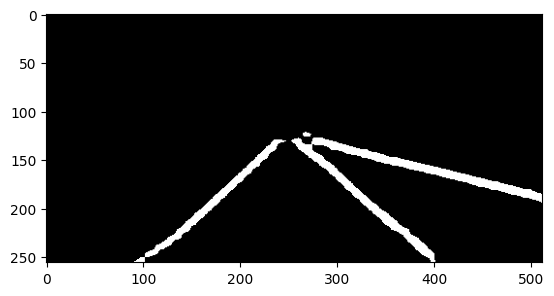

In [25]:
import matplotlib.pyplot as plt

plt.imshow(bw_mask[0])

In [26]:
np.unique(insts.detach().cpu().numpy())

array([-6.5146604, -6.2937045, -6.282072 , ...,  4.66238  ,  4.9406867,
        5.1861396], dtype=float32)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def gen_mask(ins_img):
    mask = []
    for i, mask_i in enumerate(ins_img):
        binarized = mask_i * (i + 1)
        mask.append(binarized)
    mask = np.sum(np.stack(mask, axis=0), axis=0).astype(np.uint8)
    return mask

def coloring(mask):
    ins_color_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    n_ins = len(np.unique(mask)) - 1
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, n_ins)]
    for i in range(n_ins):
        ins_color_img[mask == i + 1] =\
            (np.array(colors[i][:3]) * 255).astype(np.uint8)
    return ins_color_img


def gen_instance_mask(sem_pred, ins_pred, n_obj):
    print(ins_pred.shape)
    print(sem_pred.shape)
    print(ins_pred[:, sem_pred].shape)
    embeddings = ins_pred[:, sem_pred].transpose(1, 0).detach().cpu().numpy()
    print(embeddings.shape)
    clustering = KMeans(n_obj).fit(embeddings)
    labels = clustering.labels_

    instance_mask = np.zeros_like(sem_pred, dtype=np.uint8)
    for i in range(n_obj):
        lbl = np.zeros_like(labels, dtype=np.uint8)
        lbl[labels == i] = i + 1
        instance_mask[sem_pred] += lbl

    return instance_mask

def gen_instance_mask(sem_pred, ins_pred, n_obj):
    """
    Generates an instance mask using KMeans clustering on instance embeddings.
    
    Args:
        sem_pred (torch.Tensor): Binary mask of shape (H, W) indicating valid pixels.
        ins_pred (torch.Tensor): Instance embeddings of shape (C, H, W).
        n_obj (int): Number of clusters (lanes).
    
    Returns:
        np.ndarray: Instance segmentation mask of shape (H, W).
    """

    # Ensure inputs are on CPU
    sem_pred = sem_pred.to(torch.bool).detach().cpu().numpy()
    ins_pred = ins_pred.detach().cpu().numpy()

    print("Instance Prediction Shape:", ins_pred.shape)  # (4, 512, 256)
    print("Semantic Prediction Shape:", sem_pred.shape)  # (512, 256)

    # Reshape ins_pred to (C, H*W) -> (4, 512*256)
    C, H, W = ins_pred.shape
    ins_pred = ins_pred.reshape(C, -1)  # (4, 131072)

    # Extract valid pixel embeddings
    embeddings = ins_pred[:, sem_pred.reshape(-1)].T  # Shape (num_pixels, C)

    print("Extracted Embeddings Shape:", embeddings.shape)  # (num_valid_pixels, 4)

    # Ensure we have enough valid pixels for clustering
    if embeddings.shape[0] < n_obj:
        raise ValueError(f"Not enough valid pixels ({embeddings.shape[0]}) for {n_obj} clusters.")

    # Apply KMeans clustering
    clustering = KMeans(n_clusters=n_obj, random_state=42).fit(embeddings)
    labels = clustering.labels_

    # Create instance mask (H, W) initialized to 0
    instance_mask = np.zeros((H, W), dtype=np.uint8)

    print(instance_mask.shape, sem_pred.shape)

    # Assign cluster labels to the corresponding pixels in the mask
    instance_mask[sem_pred] = labels + 1  # Labels start from 1 for visibility

    return instance_mask


def gen_color_img(sem_pred, ins_pred, n_obj):
    return coloring(gen_instance_mask(sem_pred, ins_pred, n_obj))

In [41]:
from scipy import ndimage as ndi

p_sem_pred = []
for sp in bins:
    sp = sp.cpu().numpy()
    p_sem_pred.append(ndi.morphology.binary_fill_holes(sp > 0.5))

/tmp/ipykernel_32877/2184501443.py:6: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  p_sem_pred.append(ndi.morphology.binary_fill_holes(sp > 0.5))


In [42]:
p_sem_pred[0].shape

(2, 256, 512)

Instance Prediction Shape: (4, 256, 512)
Semantic Prediction Shape: (256, 512)
Extracted Embeddings Shape: (5125, 4)
(256, 512) (256, 512)


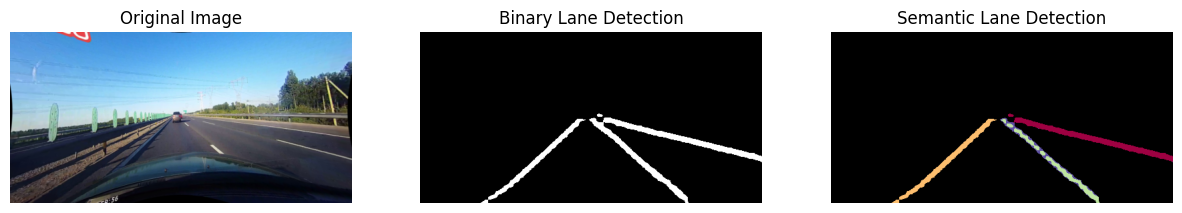

In [49]:
color_img = gen_color_img(bw_mask[0], insts[0], 4)
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(images[0].permute(1,2,0).cpu().numpy())
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(bw_mask[0], cmap='gray')
axes[1].set_title('Binary Lane Detection')
axes[1].axis('off')

axes[2].imshow(color_img)
axes[2].set_title('Semantic Lane Detection')
axes[2].axis('off')

plt.show()

